In [1]:
import napari
from napari_czifile2 import napari_get_reader
from cellpose import models, plot, utils, core, models, train
from cellpose.io import logger_setup
import cellpose.io as cio 
import torch 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours
import pandas as pd
import skimage.exposure as exposure
from skimage.morphology import remove_small_objects
import numpy as np
from skimage.measure import label, regionprops
import seaborn as sns
import os 
import sys 
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold
from skimage.exposure import equalize_adapthist
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion, gaussian_filter, binary_dilation, binary_fill_holes
from skimage import exposure
import sys 
from plotting import * 
white_plotting()
import warnings
import matplotlib.font_manager as fm
fm.fontManager.__init__()
warnings.filterwarnings("ignore")
use_GPU = core.use_gpu()
torch.cuda.empty_cache()
print('>>> GPU activated? %d'%use_GPU)
logger_setup()

Initializing plotting package
>>> GPU activated? 1
2025-04-03 12:23:06,061 [INFO] WRITING LOG OUTPUT TO /home/tracking/.cellpose/run.log
2025-04-03 12:23:06,062 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.12.8 
torch version:  	2.5.1+cu124


(<Logger cellpose.io (INFO)>, PosixPath('/home/tracking/.cellpose/run.log'))

In [2]:
def plot_2_channels(results, c1, c2, c1_name, c2_name, c1_color, c2_color, coordinates, image, metadata, all_rois, input, file, 
                    pixel_bounds=100, bbox_expansion=5, 
                    dapi_max=255, c1_max=255, c2_max=255): 
    
    # Remove -T from column names
    results = results.copy() 
    results.columns = results.columns.str.split('-T').str[0]

    # Make figure directory
    figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-{c1_name}-{c2_name}'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    # Clear directory
    for f in os.listdir(figure_dir):
        os.remove(os.path.join(figure_dir, f))

    # Scatter Plot 
    f, ax = plt.subplots(1, 1, figsize=(2, 2), dpi = 400) 
    sns.scatterplot(data=results, x=c1, y=c2, s=10, ax=ax, color='black', alpha=0.3, lw=0)

    # Plot coordinates using the data from the image 
    results_image = results[results['image'] == file].reset_index(drop=True)
    random_colors = sns.color_palette('colorblind', len(coordinates))
    cells = [] 
    for i, coord in enumerate(coordinates): 
        cell_idx = np.argmin(np.linalg.norm(results_image[[c1, c2]].values - coord, axis=1))
        cell = results_image.iloc[cell_idx].copy()  
        sns.scatterplot(data=pd.DataFrame([cell]), x=c1, y=c2, color=random_colors[i], s=30, ax=ax, lw=0, alpha=1)
        cell["color"] = random_colors[i] 
        cell["number"] = i + 1
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Plotting 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"Normalized {c1_name} Intensity", fontsize=6) 
    ax.set_ylabel(f"Normalized {c2_name} Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2]])]

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)

        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        c1_index = [idx for idx, channel in channels if c1 in channel][0]
        c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
        if c1_color == "magenta": 
            rgb_image[..., 0] += c1_adjusted  
            rgb_image[..., 2] += c1_adjusted  
        elif c1_color == "cyan": 
            rgb_image[..., 1] += c1_adjusted
            rgb_image[..., 2] += c1_adjusted
        elif c1_color == "yellow": 
            rgb_image[..., 0] += c1_adjusted
            rgb_image[..., 1] += c1_adjusted

        # -- Cyan (c2): add to green and blue
        c2_index = [idx for idx, channel in channels if c2 in channel][0]
        c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
        if c2_color == "magenta": 
            rgb_image[..., 0] += c2_adjusted  
            rgb_image[..., 2] += c2_adjusted  
        elif c2_color == "cyan": 
            rgb_image[..., 1] += c2_adjusted
            rgb_image[..., 2] += c2_adjusted
        elif c2_color == "yellow": 
            rgb_image[..., 0] += c2_adjusted
            rgb_image[..., 1] += c2_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        # Adjust fig size and width ratios as needed.
        fig_width = 1   # total width (main image + zoom panels)
        fig_height = 0.75  # height of the main image (zoom panels share this height)
        f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
        gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[4, 1])
        ax_main = f.add_subplot(gs[:, 0])
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        ax_zoom_magenta = f.add_subplot(gs[1, 1])
        ax_zoom_cyan = f.add_subplot(gs[2, 1])

        # Plot main composite image
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add border to main image
        ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, fill=False, edgecolor=cell['color'], lw=2))
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='bold')
        ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='bold')
        ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='bold')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))

        # Zoom for Magenta (c1)
        zoom_c1 = c1_adjusted[y1:y2, x1:x2]
        # Build an RGB image: red and blue channels from c1
        zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
        if c1_color == "magenta": 
            zoom_c1_rgb[..., 0] += zoom_c1  
            zoom_c1_rgb[..., 2] += zoom_c1  
        elif c1_color == "cyan": 
            zoom_c1_rgb[..., 1] += zoom_c1
            zoom_c1_rgb[..., 2] += zoom_c1
        elif c1_color == "yellow": 
            zoom_c1_rgb[..., 0] += zoom_c1
            zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
        ax_zoom_magenta.imshow(zoom_c1_rgb)
        ax_zoom_magenta.axis("off")
        ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor='magenta', lw=1))

        # Zoom for Cyan (c2)
        zoom_c2 = c2_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
        if c2_color == "magenta": 
            zoom_c2_rgb[..., 0] += zoom_c2  
            zoom_c2_rgb[..., 2] += zoom_c2  
        elif c2_color == "cyan": 
            zoom_c2_rgb[..., 1] += zoom_c2
            zoom_c2_rgb[..., 2] += zoom_c2
        elif c2_color == "yellow": 
            zoom_c2_rgb[..., 0] += zoom_c2
            zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
        ax_zoom_cyan.imshow(zoom_c2_rgb)
        ax_zoom_cyan.axis("off")
        ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor='cyan', lw=1))

        plt.tight_layout(pad=0)
        plt.show()

## 20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi
- file_number = 0, no threshold necessary 
- file_number = 1, threshold = 40 
- file_number = 2, threshold 60 
- file_number = 3, no threshold necessary 
- file_number = 4, threshold = 55

In [53]:
file_number = 4

In [54]:
input = '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi'
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E129", "LOC104", "9E116"]

In [55]:
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('.csv')]

# Specify results file 
results_file = results_files[file_number]
results_path = os.path.join(results_dir, results_file)
results = pd.read_csv(results_path)

results

,z_id,image,z,count,area,centroid_x,centroid_y,AF546,AF488,AF647
0,1,20250328 4 KLF sample 1.czi,7,0,7.508151,1211.348101,486.402532,3.136709,17.954430,4.179747
1,1,20250328 4 KLF sample 1.czi,8,1,5.027610,1257.635161,365.733459,3.362949,17.574669,3.499055
2,2,20250328 4 KLF sample 1.czi,9,2,6.415192,1137.534815,244.838519,3.074074,21.453333,3.176296
3,3,20250328 4 KLF sample 1.czi,9,3,6.842872,1119.920833,271.870833,3.161111,21.733333,3.362500
4,4,20250328 4 KLF sample 1.czi,9,4,6.225113,1148.995420,289.077863,2.937405,18.294656,2.974046
...,...,...,...,...,...,...,...,...,...,...
26102,6,20250328 4 KLF sample 1.czi,80,26104,7.061464,1144.580081,604.755047,8.454913,21.107672,8.118439
26103,7,20250328 4 KLF sample 1.czi,80,26105,4.742490,1125.196393,640.114228,12.569138,22.825651,17.496994
26104,8,20250328 4 KLF sample 1.czi,80,26106,5.911481,991.773312,967.617363,13.008039,22.702572,14.728296
26105,9,20250328 4 KLF sample 1.czi,80,26107,6.234617,1058.408537,979.440549,10.205793,23.213415,12.730183


In [108]:
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../raw-data/20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi/20250328 4 KLF sample 1.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 94, 4, 2048, 2048)
Loaded ../results/20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi/20250328 4 KLF sample 1_rois.npy


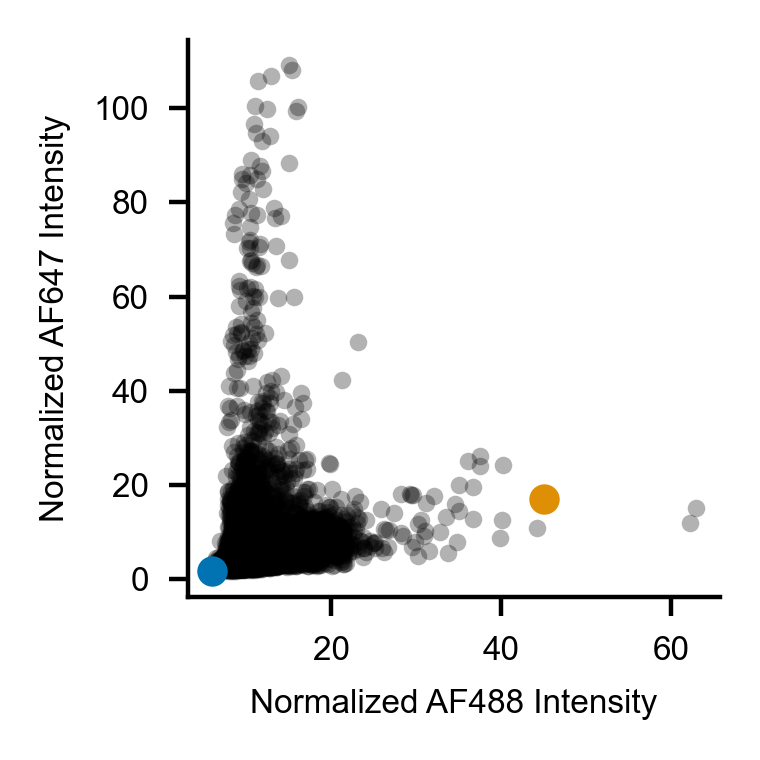

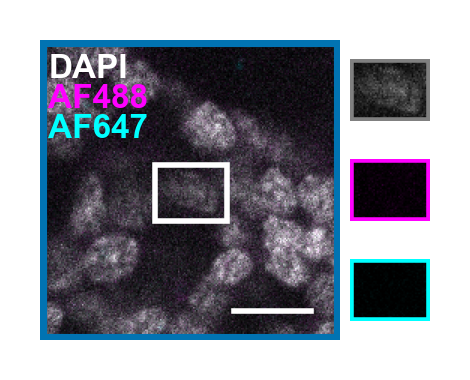

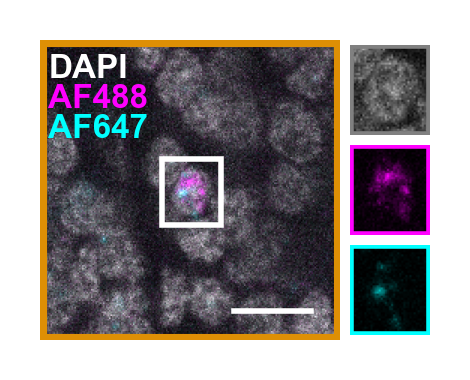

In [109]:
# T79-intergenic-b2-647 T79-exonic-b1-546 DAPI
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, input=input, file=image, 
                c1="AF488", c2="AF647", 
                c1_name="AF488", c2_name="AF647", 
                c1_color="magenta", c2_color="cyan",
                coordinates=[[0, 0], [50, 20]], 
                dapi_max=255, c1_max=200, c2_max=200)

In [110]:
# Rewrite results after applying the threshold
results_thresholded = results[results["AF488"] < 55].reset_index(drop=True)
results_thresholded.to_csv(results_path, index=False)

## 20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI
- file_number = 0, no threshold
- file_number = 1, no threshold
- file_number = 2, no threshold
- file_number = 3, no threshold
- file_number = 4, no threshold
- file_number = 5, no threshold

In [18]:
file_number = 5

In [19]:
input = '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI'
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["LOC105282603", "9E108", "9E116"]

In [20]:
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('.csv')]

# Specify results file 
results_file = results_files[file_number]
results_path = os.path.join(results_dir, results_file)
results = pd.read_csv(results_path)

results

,z_id,image,z,count,area,centroid_x,centroid_y,AF546-T1,AF488-T2,AF647-T3
0,1,20250328 5 ZP sample 2.czi,9,0,6.728824,685.692090,498.062147,2.970339,26.492938,5.420904
1,2,20250328 5 ZP sample 2.czi,9,1,4.942074,664.263462,515.019231,2.613462,22.557692,5.967308
2,1,20250328 5 ZP sample 2.czi,10,2,7.004440,660.127544,480.100407,2.583446,20.373134,5.777476
3,2,20250328 5 ZP sample 2.czi,10,3,8.097398,687.676056,495.208920,2.521127,19.907277,5.421362
4,3,20250328 5 ZP sample 2.czi,10,4,6.206105,665.094946,515.574273,2.402757,18.289433,5.620214
...,...,...,...,...,...,...,...,...,...,...
20910,2,20250328 5 ZP sample 2.czi,85,20910,4.932570,1085.834297,1032.843931,7.098266,29.102119,17.526012
20911,3,20250328 5 ZP sample 2.czi,85,20911,7.489143,1136.279188,1050.526650,7.729695,29.390863,18.219543
20912,4,20250328 5 ZP sample 2.czi,85,20912,5.616857,1096.900169,1062.976311,7.857868,29.602369,21.771574
20913,5,20250328 5 ZP sample 2.czi,85,20913,5.018106,1144.259470,1082.606061,7.335227,27.306818,17.515152


In [21]:
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../raw-data/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 2.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 88, 4, 2048, 2048)
Loaded ../results/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 2_rois.npy


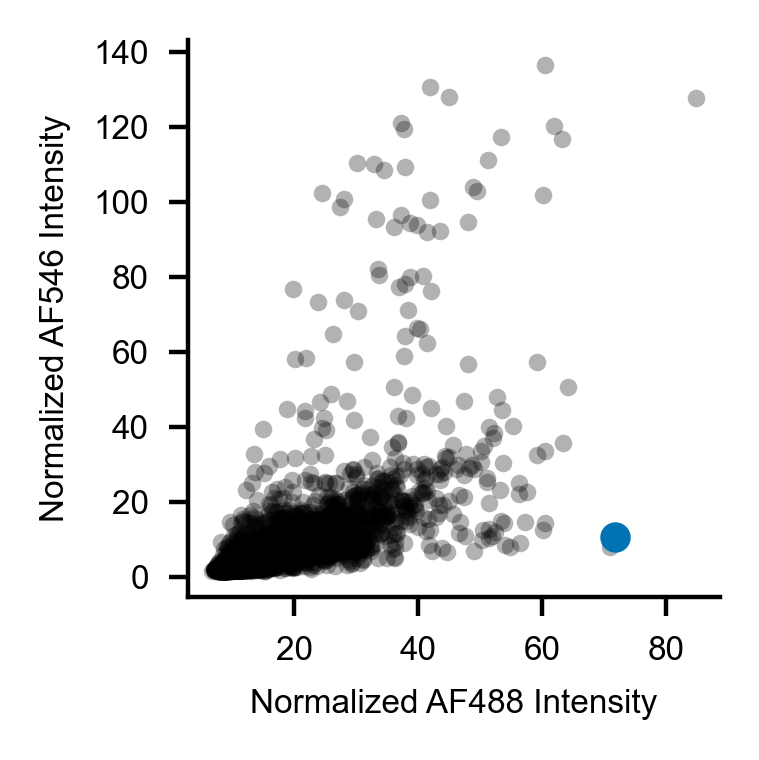

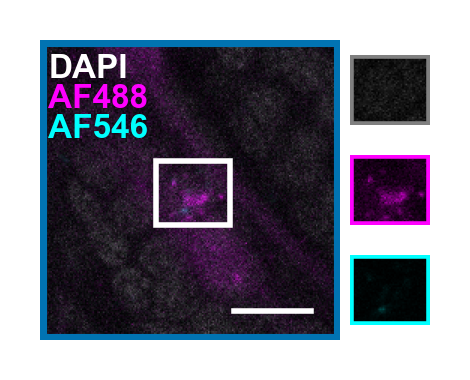

In [22]:
# T79-intergenic-b2-647 T79-exonic-b1-546 DAPI
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, input=input, file=image, 
                c1="AF488", c2="AF546", 
                c1_name="AF488", c2_name="AF546", 
                c1_color="magenta", c2_color="cyan",
                coordinates=[[150, 0]], 
                dapi_max=255, c1_max=200, c2_max=200)

In [ ]:
# Rewrite results after applying the threshold
#results_thresholded = results[results["AF488-T2"] < 55].reset_index(drop=True)
#results_thresholded.to_csv(results_path, index=False)